In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Keplerian Orbit (2 body problem)
$$H(p, q) = \frac{p^2}{2} - \frac{1}{\lVert q \rVert_2}, \quad p, q \in \mathbb{R}^2.$$

In [2]:
import os
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
sys.path.append("..")
from prepare_data import PrepareData, SimulateTwoBody  # noqa E402
from GFNN import GFNN  # noqa E402
from orbital import Orb2PosVel, PosVel2Orb  # noqa E402

### Prepare Data

In [3]:
CURRENT_DIR = str(pathlib.Path(".").parent.absolute())
h = 0.1
train_file_path, test_file_path = PrepareData(CURRENT_DIR + "/data",
                                              h=h,
                                              n_train=100000,
                                              n_test=100,
                                              seq_len=2,
                                              n_processors=1)

parameters = {
    "dim": 2,
    "step_size": h,
    "train_file_path": train_file_path,
    "test_file_path": test_file_path,
    "batch_size": 200,
    "n_neurons": [4, 200, 100, 50, 20, 1],
    "lr": 1e-2,
}

STORAGE_DIR = CURRENT_DIR + "/h=" + str(h) + "/"
if not os.path.exists(STORAGE_DIR):
    os.mkdir(STORAGE_DIR)

Training data already exists.
Testing data already exists.


### Initialize (load) the model

In [4]:
nn = GFNN(parameters)
# If saved checkpoint of GFNN exists, load GFNN from the checkpoint.
# Uncomment the following two lines if a loaded GFNN is deseired.
# if os.path.exists(STORAGE_DIR + "/checkpoint.pt"):
#     nn.Load(STORAGE_DIR)

### Train

In [5]:
# Train.
epochs = 20
nn.Train(epochs)

# Serialize the trained model.
nn.Save(STORAGE_DIR)

Epoch 20: training loss=1.16e-08, testing loss=1.10e-08: 100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


Text(0, 0.5, 'training loss')

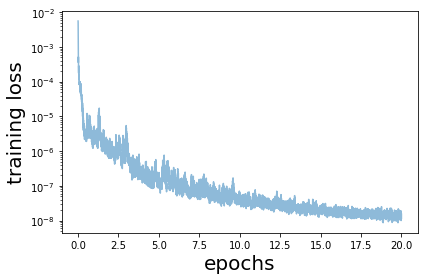

In [6]:
fig, ax = plt.subplots(tight_layout=True)
ax.semilogy((np.arange(len(nn.loss_array))+1)/(nn.n_train/nn.args["batch_size"]), nn.loss_array, alpha=0.5)
ax.set_xlabel("epochs", fontsize=20)
ax.set_ylabel("training loss", fontsize=20)

### Predict

In [7]:
def EvolveFlow(nn, q, p, n):
    """
    Evolve the flow by the trained GFNN.
    Args:
        q,p the initial condition
        n the steps to evolve
        nn the neural network
    """
    h = nn.args["step_size"]
    qspan = [q]
    pspan = [p]
    t = 0
    tspan = [t]
    for i in range(n):
        # one step evolution
        q, p = nn.Predict(q, p)
        t = t + h
        qspan.append(q)
        pspan.append(p)
        tspan.append(t)
    return np.array(tspan), np.array(qspan), np.array(pspan)

#### Evolve the flow

In [8]:
# Initial condition for prediction
q = np.array([0.98, 0.])
p = np.array([0.0, 1.02])
steps = 1000

h_nn = nn.args["step_size"]
dim = nn.args["dim"]

h_sim = 0.01
ret_sim = SimulateTwoBody(np.array(q), np.array(p),
                          h_sim, int(steps * h_nn / h_sim))
qspan_sim = ret_sim[:, 0:dim]
pspan_sim = ret_sim[:, dim:2 * dim]
tspan_sim = h_sim * np.arange(0, qspan_sim.shape[0])
tspan_nn, qspan_nn, pspan_nn = EvolveFlow(nn, q, p, steps)

#### Convert $q, p$ to orbital elements

In [9]:
orbs_sim = np.zeros((qspan_sim.shape[0], 6))
for i in range(qspan_sim.shape[0]):
    pos, vel = qspan_sim[i], pspan_sim[i]
    orb = PosVel2Orb(pos, vel, 1.0)
    orbs_sim[i, :] = orb
orbs_nn = np.zeros((qspan_nn.shape[0], 6))
for i in range(qspan_nn.shape[0]):
    pos, vel = qspan_nn[i], pspan_nn[i]
    orb = PosVel2Orb(pos, vel, 1.0)
    orbs_nn[i, :] = orb

/home/yo/Dropbox (GaTech)/ICML_code/2body/orbital.py:65: RuntimeWarning: invalid value encountered in double_scalars
  val = n[0] / n_norm
/home/yo/Dropbox (GaTech)/ICML_code/2body/orbital.py:74: RuntimeWarning: invalid value encountered in double_scalars
  val = np.dot(n, vec_e) / n_norm / e


#### Plot

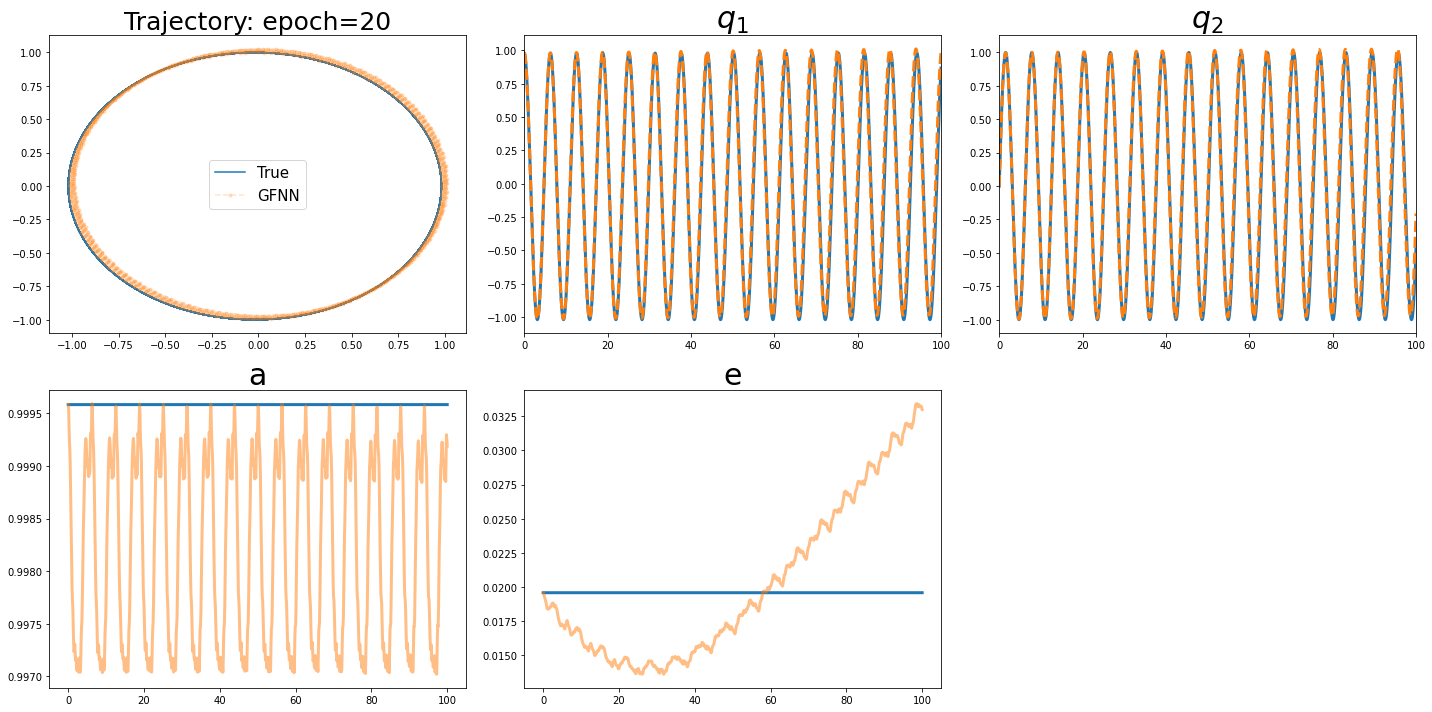

In [10]:
fig = plt.figure(tight_layout=True, figsize=(20, 10))
gs = gridspec.GridSpec(2, 3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(qspan_sim[:, 0], qspan_sim[:, 1], label='True')
ax.plot(qspan_nn[:, 0], qspan_nn[:, 1], '.--',
        label='GFNN', alpha=0.2)
ax.set_title("Trajectory: epoch="+str(nn.epoch), fontsize=25)
ax.legend(fontsize=15)

names = ["$q_1$", "$q_2$"]
for i in range(2):
    ax = fig.add_subplot(gs[0, i+1])
    ax.plot(tspan_sim, qspan_sim[:, i], linewidth=3, label="True")
    ax.plot(tspan_nn, qspan_nn[:, i], "--", linewidth=3, label="GFNN")
    ax.set_title(names[i], fontsize=30)
    ax.set_xlim([0, 100])

names = ["a", "e"]
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    ax.plot(tspan_sim, orbs_sim[:, i], linewidth=3, label="True")
    ax.plot(tspan_nn, orbs_nn[:, i], linewidth=3, label="GFNN", alpha=0.5)
    ax.set_title(names[i], fontsize=30)